In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             mean_absolute_error)
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
# read and concat data
X_chall = pd.read_csv('processed_challenger_match_data.csv')
X_gm = pd.read_csv('processed_gm_match_data.csv')
X_full = pd.concat([X_chall, X_gm], axis = 'index')


In [3]:
# remove duplicates
X_full = X_full.drop_duplicates().copy()

In [4]:
X_full

,augments_0,augments_1,augments_2,last_round,level,placement,puuid,time_eliminated,total_damage_to_players,traits_0_name,...,units_0_itemNames_2,units_1_itemNames_1,units_1_itemNames_2,units_8_itemNames_0,traits_13_name,traits_13_num_units,traits_13_style,traits_13_tier_current,traits_13_tier_total,units_8_itemNames_1
0,TFT6_Augment_SecondWind1,TFT8_Augment_CamilleSupport,TFT6_Augment_Battlemage2,38,9,2,DEbaPlFrC4zO82TEpi3t7y2hNHtmK-arqELEr9xFg2wAGd...,2222.908691,187,Set8_Admin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TFT6_Augment_TinyTitans,TFT8_Augment_YasuoSupport,TFT6_Augment_ThrillOfTheHunt2,31,8,4,OjsqAVv82-EgbyBKCGvxEYJXzj2rIwZNSgedH0tGDsmPuh...,1848.075317,61,Set8_Aegis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TFT6_Augment_ItemGrabBag1,TFT8_Augment_JinxSupport,TFT6_Augment_JeweledLotus,34,8,3,jgpLaQ_pq7dnciSw_WhHatWg6mPP9lon0wbl0_sAOtgzHs...,2021.468140,137,Set8_Ace,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TFT7_Augment_PandorasBench,TFT8_Augment_FioraSupport,TFT8_Augment_OxForceEmblem,31,8,6,rmOXPE23Zt8SFLskHgIJyZq3xLmTeC0vGnk6ZWG-sZEuk0...,1848.173584,81,Set8_Ace,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TFT7_Augment_BandOfThieves1,TFT8_Augment_CamilleSupport,TFT6_Augment_JeweledLotus,38,8,1,t5lnvjlGvNBtbqxkMe_6pWSuSwy0_Wfnikdx802h1dZyKd...,2223.555176,187,Set8_Admin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,TFT8_Augment_PoppySupport,TFT8_Augment_DefenderEmblem,TFT6_Augment_WindfallPlusPlus,24,8,8,F0srTxdd4ToawiyllilNE69eudWC0peERMGKTMVgCWsmPp...,1451.850220,45,Set8_Ace,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6388,TFT8_Augment_WukongSupport,TFT6_Augment_RichGetRicherPlus,TFT7_Augment_ThinkFast,34,8,3,Cy0PapLpaqp7hXC4-FvGHRUNlz2w7M8RGy2KfwHYBBs8PT...,2062.919922,134,Set8_Aegis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6389,TFT8_Augment_PoppyCarry,TFT6_Augment_SecondWind2,TFT8_Augment_GenAEEmblem2,35,8,2,8OEyovRo2Gllne49XLfuY-WWc9aVj8hiLx5rX5kvdD8T42...,2123.685791,139,Set8_Admin,...,TFT8_Item_TitansResolve_GenAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6390,TFT8_Augment_RenektonCarry,TFT6_Augment_PortableForge,TFT6_Augment_RadiantRelics,27,7,7,2_4-JXmMg_9SSp9s2tYXb0Uk_QDbKp_fwa_bRi9ZktaAYg...,1629.171753,69,Set8_Admin,...,NaN,TFT_Item_HextechGunblade,TFT_Item_InfinityEdge,NaN,NaN,NaN,NaN,NaN,NaN,NaN


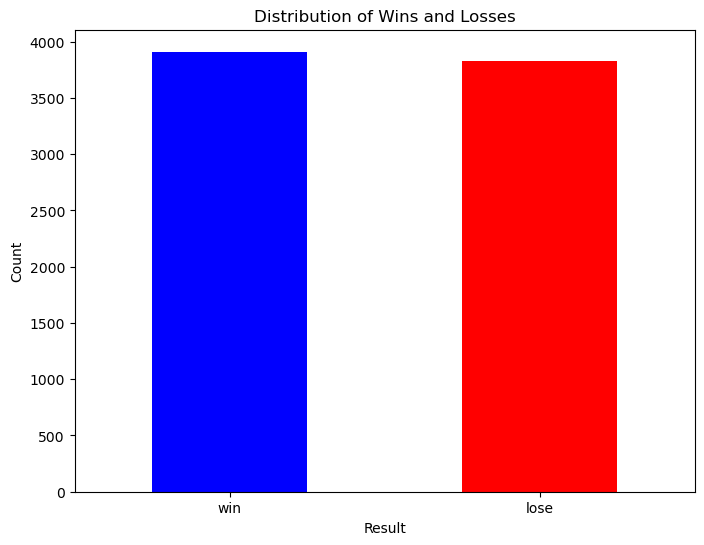

In [5]:
# Convert 'placement' into 'win' or 'lose'
X_full['result'] = X_full['placement'].apply(lambda x: 'win' if 1 <= x <= 4 else 'lose')

# Plotting the distribution of 'win' vs 'lose'
plt.figure(figsize=(8, 6))
X_full['result'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Wins and Losses')
plt.xlabel('Result')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

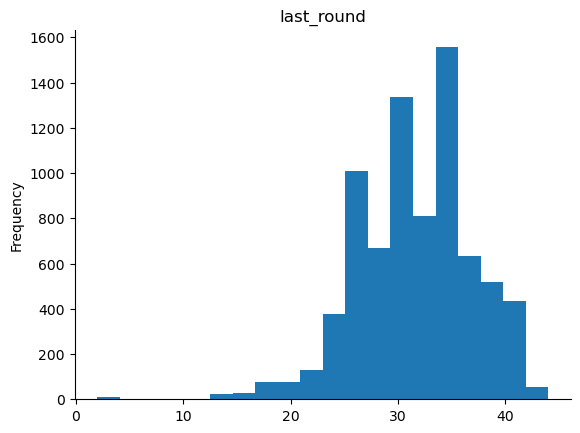

In [6]:
from matplotlib import pyplot as plt
X_full['last_round'].plot(kind='hist', bins=20, title='last_round')
plt.gca().spines[['top', 'right',]].set_visible(False)

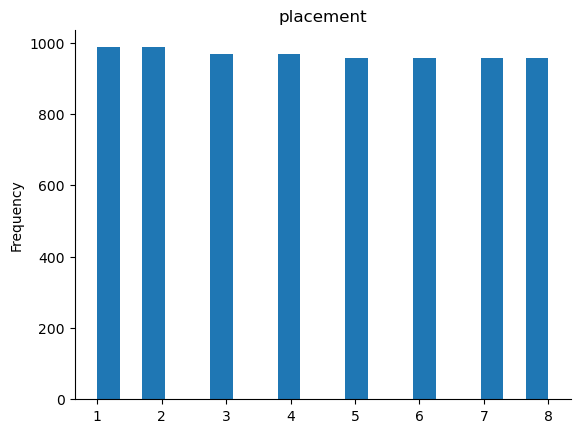

In [7]:
from matplotlib import pyplot as plt
X_full['placement'].plot(kind='hist', bins=20, title='placement')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
import re
# filter columns
features = ['level', 'placement']

trait_names = re.compile("traits_._name")
trait_nums = re.compile("traits_._num")
trait_tier_current = re.compile("traits_._tier_current")
trait_tier_total = re.compile("traits_._tier_total")
units_id = re.compile("units_._character")
units_rarity = re.compile("units_._rarity")
units_tier = re.compile("units_._tier")
itemnames = re.compile("units_._itemNames")
needed_columns = [ trait_names, trait_nums, trait_tier_current, trait_tier_total, units_id, units_rarity, units_tier, itemnames]
combine_columns = [ trait_names, trait_nums, trait_tier_current, trait_tier_total, units_id, units_rarity, units_tier, itemnames]

In [9]:
for filters in needed_columns:
    features += list(filter(filters.match, X_full.columns))

X = X_full[features]

In [10]:
for filters in combine_columns:
    features += list(filter(filters.match, X_full.columns))

X_comebine = X_full[features]

In [11]:
# convert dtypes of discrete columns
for colname in list(X.select_dtypes("float64")):
    X[colname] = X[colname].astype(float).astype("Int64")

# create new feature for total item number
item_columns = [column for column in X.columns if 'item' in column]
X['total_items'] = X[item_columns].count(axis = 'columns').copy()
X = X.drop(item_columns, axis = 'columns')

# change NaNs of categoricals
X = X.fillna(0)

/var/folders/2r/lkmkhwss2rjbxkptb7z7g63r0000gn/T/ipykernel_15524/3904245914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[colname] = X[colname].astype(float).astype("Int64")
/var/folders/2r/lkmkhwss2rjbxkptb7z7g63r0000gn/T/ipykernel_15524/3904245914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[colname] = X[colname].astype(float).astype("Int64")
/var/folders/2r/lkmkhwss2rjbxkptb7z7g63r0000gn/T/ipykernel_15524/3904245914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [12]:
# # one-hot encoding of categoricals
categoricals = [column for column in X.columns if ('name' in column) or ('id' in column)]
X = pd.get_dummies(X, columns = categoricals)
X = X.replace(np.nan, 0)

In [13]:
# select target
y = X.placement
X = X.drop('placement', axis = 'columns')

In [14]:
# create classifications with 8 bins, 4 bins and 2 bins
X8 = X4 = X2 = X
y8 = y # 8 possible classifications
y4 = y.replace({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4}) # 4 possible classifications
y2 = y.replace({1:1, 2:1, 3:1, 4:1, 5:2, 6:2, 7:2, 8:2}) # 2 possible classifications


In [15]:
X

,level,traits_0_num_units,traits_1_num_units,traits_2_num_units,traits_3_num_units,traits_4_num_units,traits_5_num_units,traits_6_num_units,traits_7_num_units,traits_8_num_units,...,units_8_character_id_TFT8_Sett,units_8_character_id_TFT8_Soraka,units_8_character_id_TFT8_Sylas,units_8_character_id_TFT8_Syndra,units_8_character_id_TFT8_Taliyah,units_8_character_id_TFT8_Urgot,units_8_character_id_TFT8_Vayne,units_8_character_id_TFT8_Vi,units_8_character_id_TFT8_Zac,units_8_character_id_TFT8_Zed
0,9,2,2,2,1,1,2,4,1,3,...,False,False,False,False,False,True,False,False,False,False
1,8,1,1,1,4,1,2,1,1,1,...,False,False,False,False,False,False,False,False,False,False
2,8,1,1,5,2,1,1,1,2,1,...,False,False,False,False,False,False,False,False,False,False
3,8,1,2,1,2,1,1,4,1,1,...,False,False,False,False,False,False,False,False,False,False
4,8,4,2,2,1,1,2,2,1,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,8,1,1,2,2,4,4,1,1,2,...,False,False,False,False,False,False,False,False,False,False
6388,8,2,2,1,2,3,1,1,3,1,...,False,False,False,False,False,False,False,False,False,False
6389,8,2,1,4,1,1,1,5,2,2,...,False,False,False,False,False,False,False,False,False,False
6390,7,2,1,1,6,1,1,2,1,1,...,False,False,False,False,False,False,False,False,False,False


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

y2 = y.replace({1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1})
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size = 0.20, random_state = 20240226)
# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameters for GridSearchCV (you can define your own grid to search over)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Perform grid search
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=4)
xgb_grid.fit(X2_train, y2_train)

# Best parameters and model
print("Best parameters found: ", xgb_grid.best_params_)
best_xgb_model = xgb_grid.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x00007ff84a4e2780 (most recent call first):
  <no Python frame>


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Make predictions
y_pred = xgb_grid.predict(X2_valid)

# Calculate accuracy
accuracy = accuracy_score(y2_valid, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1_score = f1_score(y2_valid, y_pred)
print(f"Accuracy: {f1_score:.4f}")



In [ ]:
importances = best_xgb_model.feature_importances_
feature_names = X2_train.columns
# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order and select the top 20
top_50_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(50)

top_50_features

In [ ]:
# Filter features starting with 'units_*_character_id_'
units_character_id_features = feature_importance_df[feature_importance_df['Feature'].str.contains(r'^units_\d+_character_id_')]

# Sort by importance and select the top 20
top_20_units_character_id_features = units_character_id_features.sort_values(by='Importance', ascending=False).head(20)

top_20_units_character_id_features


In [ ]:
# Filter features starting with 'units_*_character_id_'
traits_features = feature_importance_df[feature_importance_df['Feature'].str.contains(r'^traits_\d+_name_')]

# Sort by importance and select the top 20
top_50_traits_features = traits_features.sort_values(by='Importance', ascending=False).head(20)

top_50_traits_features


**Final Model Starts Here:**

In [ ]:
# read and concat data
X_chall = pd.read_csv('processed_challenger_match_data.csv')
X_gm = pd.read_csv('processed_gm_match_data.csv')
X_full = pd.concat([X_chall, X_gm], axis = 'index')
# remove duplicates
X_full = X_full.drop_duplicates().copy()
X_full
import re
# filter columns
features = ['level', 'placement']

trait_names = re.compile("traits_._name")
trait_nums = re.compile("traits_._num")
trait_tier_current = re.compile("traits_._tier_current")
trait_tier_total = re.compile("traits_._tier_total")
units_id = re.compile("units_._character")
units_rarity = re.compile("units_._rarity")
units_tier = re.compile("units_._tier")
itemnames = re.compile("units_._itemNames")
needed_columns = [ trait_names, trait_nums, trait_tier_current, trait_tier_total, units_id, units_rarity, units_tier, itemnames]
combine_columns = [ trait_names, trait_nums, trait_tier_current, trait_tier_total, units_id, units_rarity, units_tier, itemnames]

for filters in needed_columns:
    features += list(filter(filters.match, X_full.columns))

X = X_full[features]

for filters in combine_columns:
    features += list(filter(filters.match, X_full.columns))

X_combine = X_full[features]

# convert dtypes of discrete columns
for colname in list(X.select_dtypes("float64")):
    X[colname] = X[colname].astype(float).astype("Int64")

# create new feature for total item number
item_columns = [column for column in X.columns if 'item' in column]
X['total_items'] = X[item_columns].count(axis = 'columns').copy()
X = X.drop(item_columns, axis = 'columns')

# change NaNs of categoricals
X = X.fillna(0)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
# Combine the traits columns into a single list column
traits_columns = [f'traits_{i}_name' for i in range(10)]
X['combined_traits'] = X[traits_columns].apply(lambda row: [trait for trait in row if pd.notnull(trait)], axis=1)

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Convert all items in the combined list to strings
X['combined_traits'] = X['combined_traits'].apply(lambda lst: [str(item) for item in lst])

# Now, try fitting and transforming with MultiLabelBinarizer again
X_encoded = mlb.fit_transform(X['combined_traits'])

from sklearn.preprocessing import MultiLabelBinarizer

X_encoded_df = pd.DataFrame(X_encoded, columns=mlb.classes_)
X_encoded_df = X_encoded_df.drop(columns=['0'])

In [ ]:
units_columns = [f'units_{i}_character_id' for i in range(9)]
X['combined_units'] = X[units_columns].apply(lambda row: [unit for unit in row if pd.notnull(unit)], axis=1)

# Convert all items in the combined list to strings
X['combined_units'] = X['combined_units'].apply(lambda lst: [str(item) for item in lst])

# Now, try fitting and transforming with MultiLabelBinarizer again
X_encoded_units = mlb.fit_transform(X['combined_units'])

X_encoded_units_df = pd.DataFrame(X_encoded_units, columns=mlb.classes_)
X_encoded_units_df = X_encoded_units_df.drop(columns=['0'])

In [ ]:
# select target
y = X.placement
X = X.drop('placement', axis = 'columns')
# create classifications with 8 bins, 4 bins and 2 bins
X8 = X4 = X2 = X
y2 = y.replace({1:1, 2:1, 3:1, 4:1, 5:2, 6:2, 7:2, 8:2}) # 2 possible classifications


In [ ]:
y2 = y.replace({1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1})
columns_to_drop = [col for col in X2.columns if col.startswith('traits_') and '_name' in col]
X2 = X2.drop(columns=columns_to_drop, errors='ignore')
columns_to_drop = [col for col in X2.columns if col.startswith('units_') and '_character_id' in col]
X2 = X2.drop(columns=columns_to_drop, errors='ignore')
X_combined = pd.concat([X2.reset_index(drop=True), X_encoded_df.reset_index(drop=True), X_encoded_units_df.reset_index(drop=True)], axis=1)
X_combined = X_combined.drop(columns=['combined_units'])
X_combined = X_combined.drop(columns=['combined_traits'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

y2 = y.replace({1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1})
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X_combined, y2, test_size = 0.20, random_state = 20240226)
# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameters for GridSearchCV (you can define your own grid to search over)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Perform grid search
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=4)
xgb_grid.fit(X2_train, y2_train)

# Best parameters and model
print("Best parameters found: ", xgb_grid.best_params_)
best_xgb_model = xgb_grid.best_estimator_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

# Step 3: Perform the train-test split on the combined dataset
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X_combined, y2, test_size=0.20, random_state=20240226)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameters for GridSearchCV (you can define your own grid to search over)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Perform grid search
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=4, error_score='raise')
xgb_grid.fit(X2_train, y2_train)

# Best parameters and model
print("Best parameters found: ", xgb_grid.best_params_)
best_xgb_model = xgb_grid.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = xgb_grid.predict(X2_valid)

# Calculate accuracy
accuracy = accuracy_score(y2_valid, y_pred)
print(f"Accuracy: {accuracy:.4f}")


In [ ]:
importances = best_xgb_model.feature_importances_
feature_names = X2_train.columns
# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order and select the top 20
top_50_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(50)

top_50_features

In [ ]:
# Adjusting the provided code snippet to focus on filtering features that start with 'units_*_character_id_'
# and then selecting the top 20 features based on importance. This assumes 'feature_importance_df' is already defined
# with columns 'Feature' and 'Importance'.

# Filter features starting with 'units_*_character_id_'
units_character_id_features = feature_importance_df[feature_importance_df['Feature'].str.contains(r'^Set8_')]

# Sort by importance and select the top 20
top_20_units_character_id_features = units_character_id_features.sort_values(by='Importance', ascending=False).head(100)

top_20_units_character_id_features


In [ ]:
# Filter features starting with 'units_*_character_id_'
units_character_id_features = feature_importance_df[feature_importance_df['Feature'].str.contains(r'TFT8_')]

# Sort by importance and select the top 20
top_20_units_character_id_features = units_character_id_features.sort_values(by='Importance', ascending=False).head(200)

top_20_units_character_id_features
